# Bitcoin Price Prediction by ARIMA

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Exploration

In [2]:
# Load data
#/kaggle/input/bitcoin-price-dataset/bitcoin_2017_to_2023.csv
df = pd.read_csv('/kaggle/input/bitcoin-price-dataset/bitcoin_2017_to_2023.csv')
df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611


In [3]:
df.dtypes

timestamp                        object
open                            float64
high                            float64
low                             float64
close                           float64
volume                          float64
quote_asset_volume              float64
number_of_trades                  int64
taker_buy_base_asset_volume     float64
taker_buy_quote_asset_volume    float64
dtype: object

In [4]:
#indexing the df
df['timestamp'] = pd.to_datetime(df['timestamp'])

df.index = df['timestamp']

# Resampling to daily frequency
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

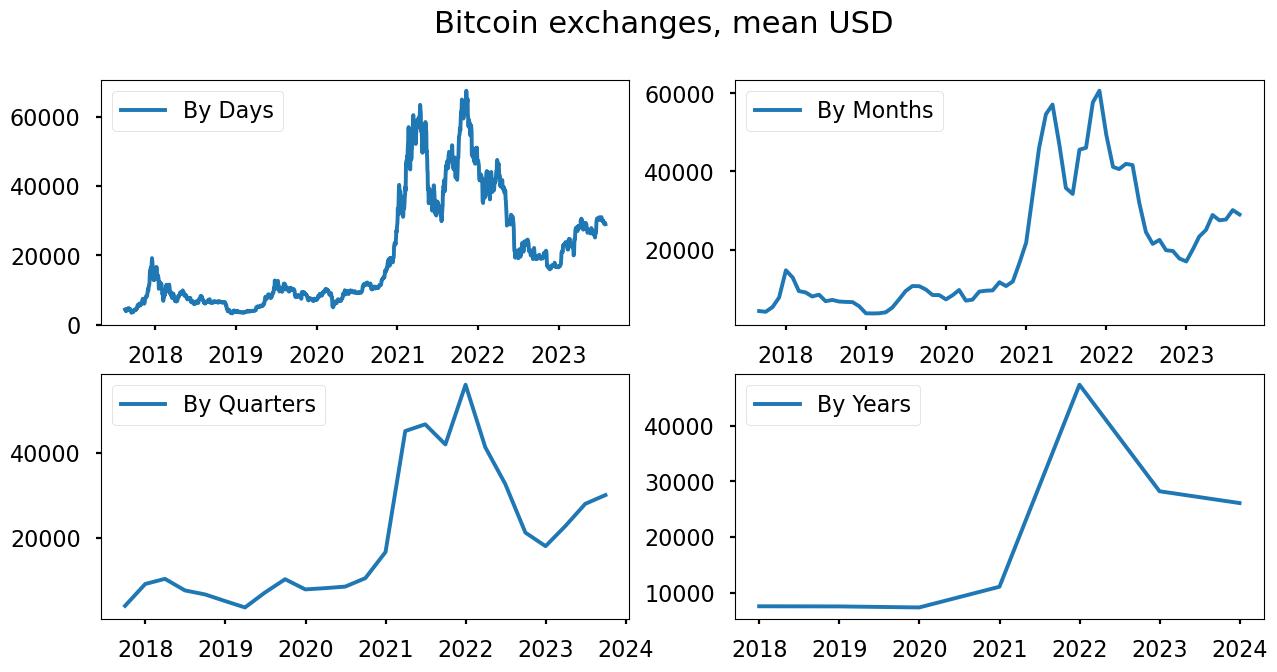

In [5]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.open, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.open, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.open, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.open, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

## Stationarity check and STL-decomposition of the series

Dickey–Fuller test: p=0.452026


<Figure size 1500x700 with 0 Axes>

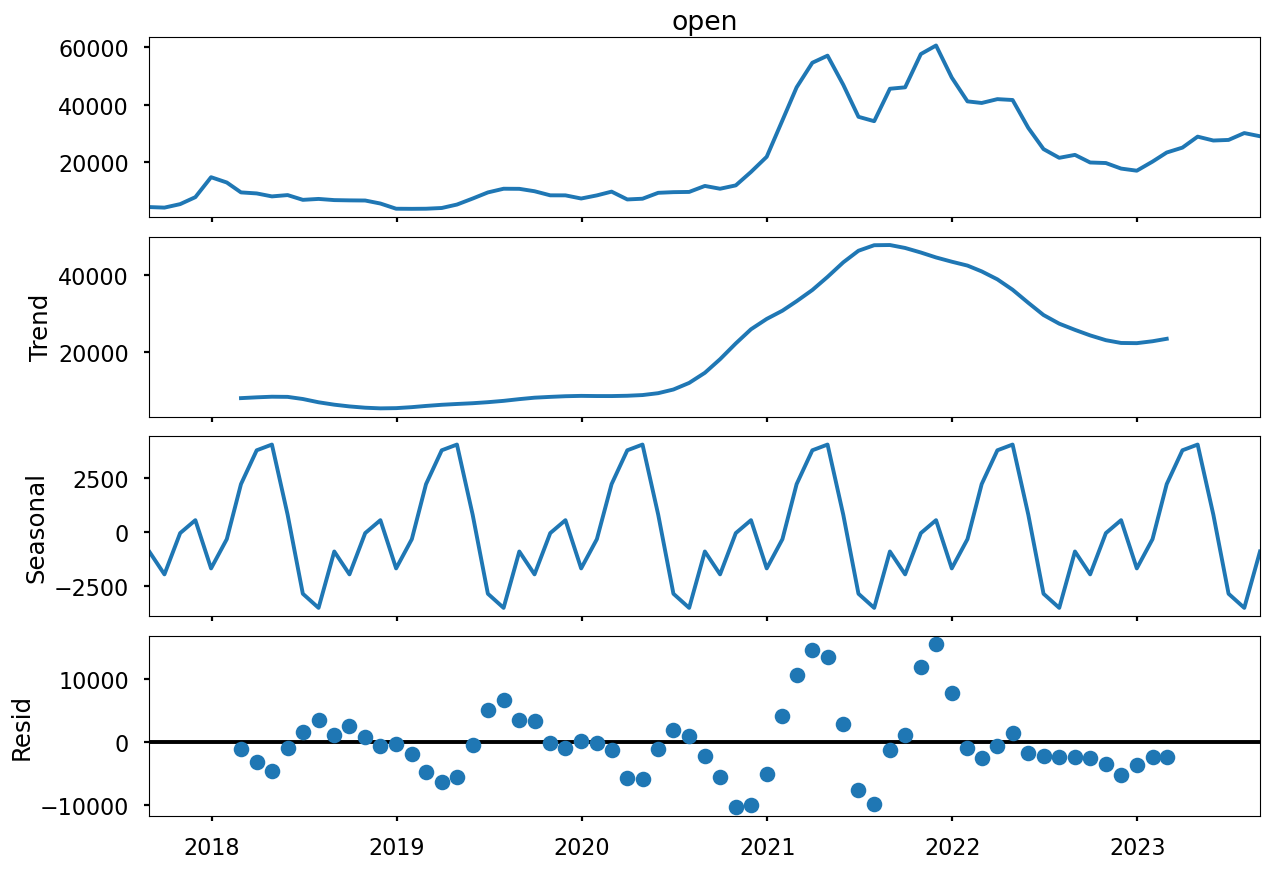

In [6]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.open).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.open)[1])
plt.show()

The series are not stationary.

## Box-Cox Transformations

In [7]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.open)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.open)[1])

Dickey–Fuller test: p=0.452026


The series are not stationary.

## Seasonal differentiation

In [8]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.084057


The series are not stationary.

## Regular differentiation

Dickey–Fuller test: p=0.000627


<Figure size 1500x700 with 0 Axes>

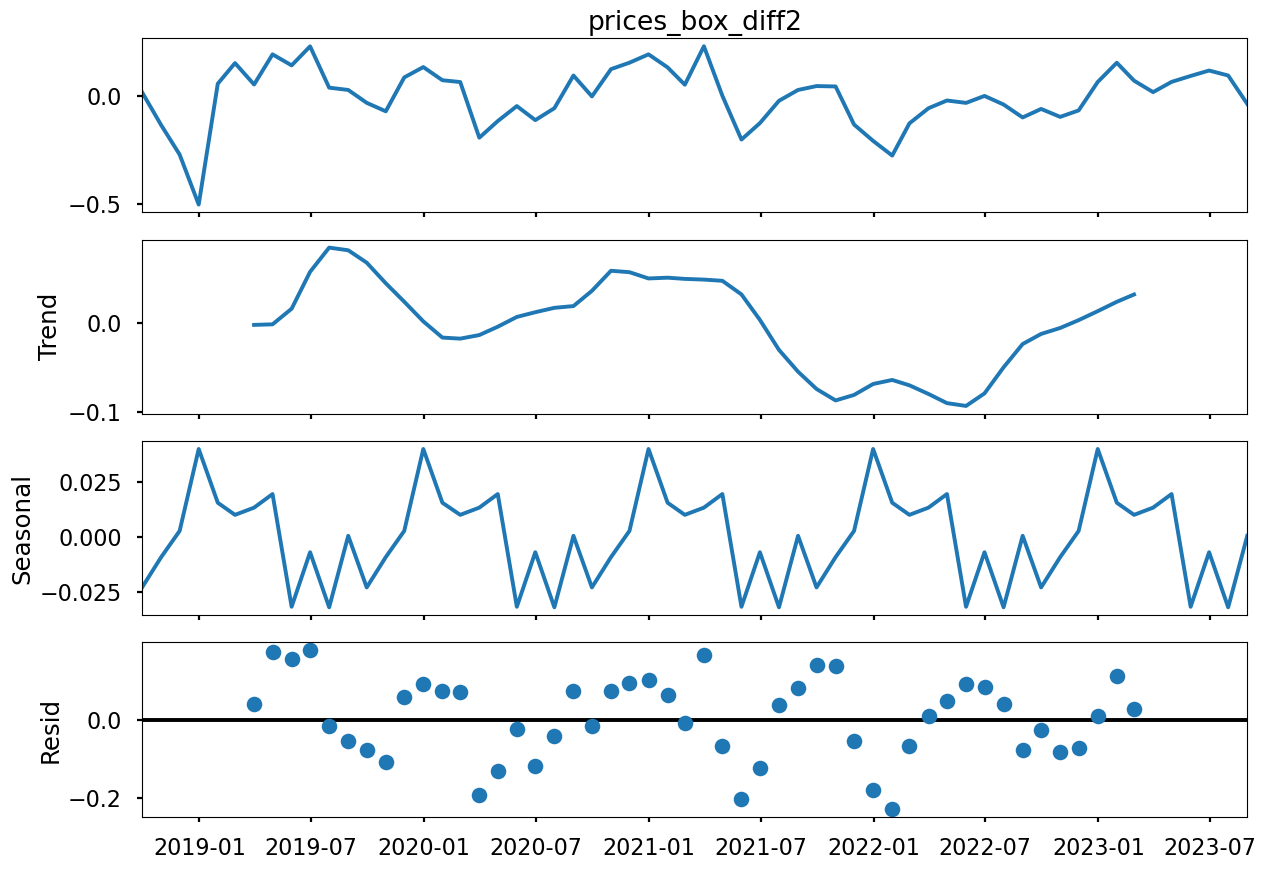

In [9]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

The series are stationary.

## Model Selection

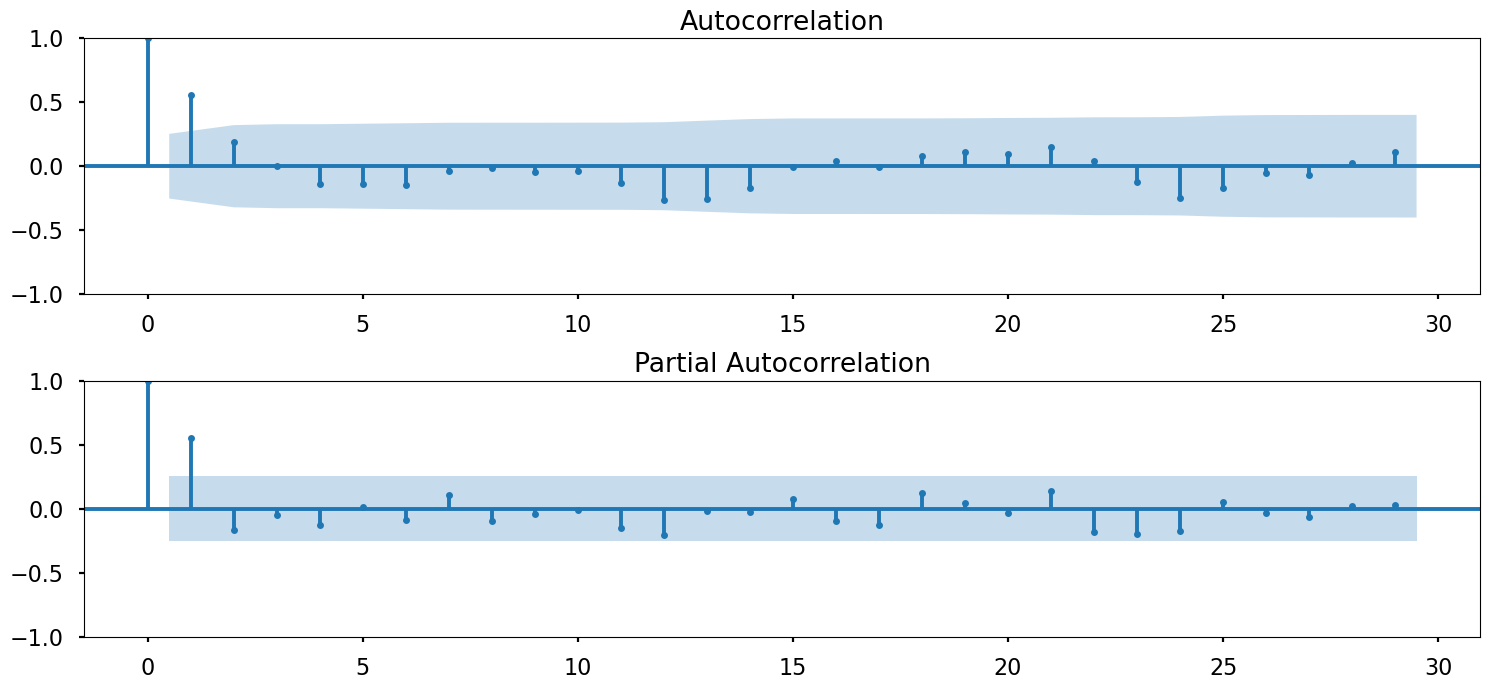

In [10]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=29, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=29, ax=ax)
plt.tight_layout()
plt.show()

In [11]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [12]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
19  (1, 0, 0, 1) -99.640843
23  (1, 0, 2, 1) -99.308022
7   (0, 1, 0, 1) -99.195515
22  (1, 0, 2, 0) -98.668120
37  (2, 0, 0, 1) -98.667623
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                   73
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  52.820
Date:                              Tue, 31 Oct 2023   AIC                            -99.641
Time:                                      07:10:08   BIC                            -93.358
Sample:                                  08-31-2017   HQIC                           -97.183
                                       - 08-31-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

## Analysis of residues

Dickey–Fuller test:: p=0.000000


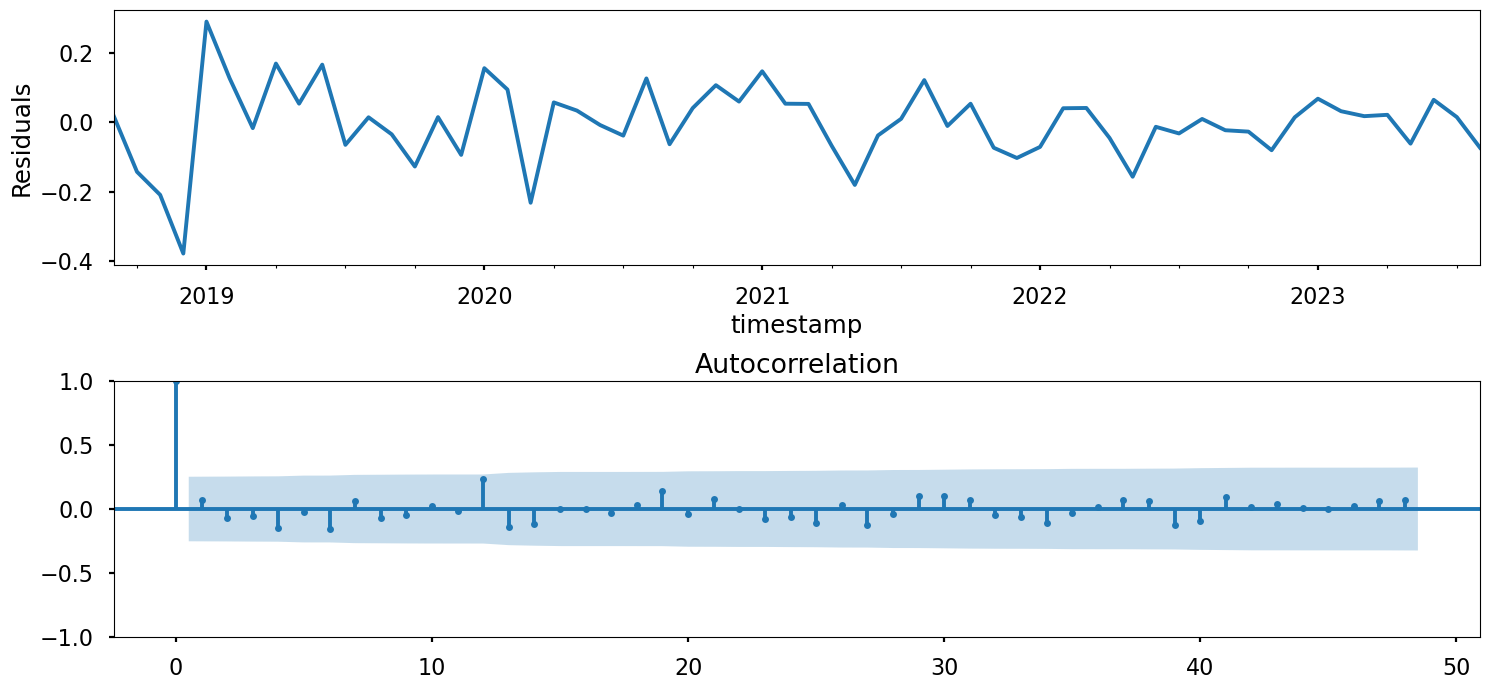

In [13]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

## Prediction

In [14]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [15]:
df_month[['open']]

,open
timestamp,
2017-08-31,4260.303469
2017-09-30,4067.458941
2017-10-31,5285.744230
2017-11-30,7719.887011
2017-12-31,14679.699692
...,...
2023-04-30,28833.265761
2023-05-31,27480.968633
2023-06-30,27686.289966


In [16]:
df_month.columns

Index(['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'Weighted_Price_box', 'prices_box_diff',
       'prices_box_diff2'],
      dtype='object')

In [17]:
# Prediction
df_month2 = df_month[['open']]
date_list = [datetime(2023, 6, 30), datetime(2023, 7, 31), datetime(2023, 8, 31), datetime(2023, 9, 30), 
             datetime(2023, 10, 31), datetime(2023, 11, 30)]

future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])

df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)


In [18]:
max_price = df_month2['forecast'].max()
max_price

42954387.22818611

In [19]:
#removing the outlier prediction
cleaned = df_month2[df_month2['forecast'] != max_price]

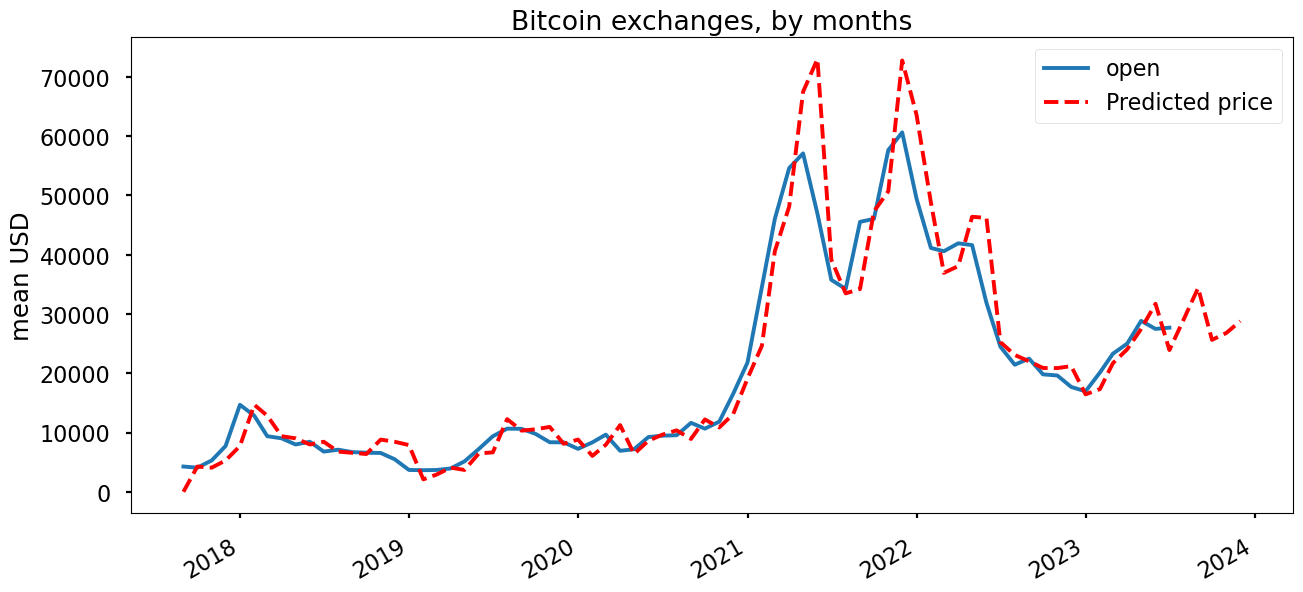

In [20]:
#plottting the predictions
plt.figure(figsize=(15,7))
df_month2.open.plot()
cleaned.forecast.plot(color='r', ls='--', label='Predicted price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

In [21]:
actual_values = df_month2['open'].dropna()  # Actual Bitcoin prices
predicted_values = cleaned['forecast'].dropna()  # Predicted Bitcoin prices

APE = abs((actual_values - predicted_values) / actual_values)
MAPE = APE.mean() * 100  # Convert to percentage
acc=117-MAPE
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(acc))

Mean Absolute Percentage Error (MAPE): 97.94%
